In [124]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools as it
from sklearn.cluster import KMeans

sys.path.append(os.path.abspath('../VoteKit'))
from votekit.pref_profile import PreferenceProfile
from votekit.ballot import Ballot
from votekit.ballot_generator import DSpatial
from votekit.ballot_generator import Clustered_DSpatial
from votekit.elections import SNTV, STV, Borda, RandomDictator, BoostedRandomDictator, PluralityVeto, fractional_transfer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Group Representation

In this example voters are sampled from a multimodal gaussian distribution with 4 centers -- representing 4 different parties. Candidates are sampled from the $\sim \text{uniform}(-3,3)$ distribution.

In [7]:
# samples a single point from mixture of gaussians
def sample_from_mixture(means, stds, weights):
    # Ensure the weights sum to 1
    weights = np.array(weights)
    weights /= weights.sum()
    
    # Choose one of the distributions based on the weights
    distribution_index = np.random.choice(len(means), p=weights)
    
    # Sample a point from the chosen distribution
    mean = means[distribution_index]
    std = stds[distribution_index]
    point = np.random.normal(loc=mean, scale=std, size=(2,))
    
    return point

In [9]:
# Choose number of voters n
# And the number of candidates m
n = 200
m = 200
candidates = [str(i) for i in range(m)]

# And the number of winners for the election
k = 20 

In [10]:
# Means for each of the 4 Gaussian distributions
means = [(-2, -2), (2, -2), (-2, 2), (2, 2)]
stds = [0.5, 0.5, 0.5, 0.5]  # Standard deviations for each Gaussian
weights = [0.25, 0.25, 0.25, 0.25]  # Weights for each Gaussian

voter_params = {'means': means, 'stds': stds, 'weights': weights}
candidate_params = {'low': -3, 'high': 3, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

generator = DSpatial(candidates = candidates,
                    voter_dist = sample_from_mixture, voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [11]:
# Generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile(number_of_ballots = n, seed = None)

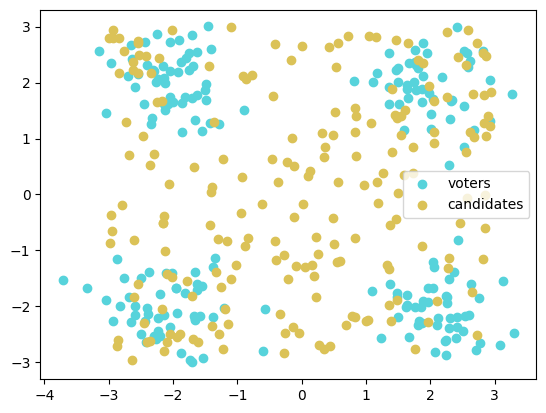

In [12]:
# visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [36]:
def election_sample(generator, n_voters):
    # Generate a profile from random candidate and voter positions
    profile, candidate_position_dict, voter_positions = generator.generate_profile(number_of_ballots = n_voters, seed = None)
    candidate_positions = np.array([i for i in candidate_position_dict.values()])
    winners = {}
    
    # SNTV
    sntv_election = SNTV(profile, k)
    sntv_results = sntv_election.run_election()
    sntv_winners = [int(list(i)[0]) for i in sntv_results.winners()]
    winners['SNTV'] = sntv_winners
    
    # STV
    stv_election = STV(profile, fractional_transfer, k, quota = 'droop')
    stv_results = stv_election.run_election()
    stv_winners = [int(list(i)[0]) for i in stv_results.winners()]
    winners['STV'] = stv_winners
    
    # k-Borda
    borda_election = Borda(profile, k)
    borda_results = borda_election.run_election()
    borda_winners = [int(list(i)[0]) for i in borda_results.winners()]
    winners['Borda'] = borda_winners
    
    # k-Random Dictator
    random_election = RandomDictator(profile, k)
    random_results = random_election.run_election()
    random_winners = [int(list(i)[0]) for i in random_results.winners()]
    winners['RandomDictator'] = random_winners
    
    # k-Boosted Random Dictator
    boosted_random_election = BoostedRandomDictator(profile, k)
    boosted_random_results = boosted_random_election.run_election()
    boosted_random_winners = [int(list(i)[0]) for i in boosted_random_results.winners()]
    winners['BoostedRandomDictator'] = boosted_random_winners
    
    # k-Plurality Veto
    plurality_veto_election = PluralityVeto(profile, k)
    plurality_veto_results = plurality_veto_election.run_election()
    plurality_veto_winners = [int(list(i)[0]) for i in plurality_veto_results.winners()]
    winners['PluralityVeto'] = plurality_veto_winners

    return voter_positions, candidate_positions, winners

In [102]:
samples = 10

sampled_voter_positions = []
sampled_candidate_positions = []
sampled_sntv_winners = []
sampled_stv_winners = []
sampled_borda_winners = []
sampled_random_winners = []
sampled_boosted_random_winners = []
sampled_plurality_veto_winners = []

for s in range(samples):
    voter_positions, candidate_positions, winners = election_sample(generator, n)
    sampled_voter_positions.append(voter_positions)
    sampled_candidate_positions.append(candidate_positions)
    sampled_sntv_winners.append(candidate_positions[winners['SNTV'],:])
    sampled_stv_winners.append(candidate_positions[winners['STV'],:])
    sampled_borda_winners.append(candidate_positions[winners['Borda'],:])
    sampled_random_winners.append(candidate_positions[winners['RandomDictator'],:])
    sampled_boosted_random_winners.append(candidate_positions[winners['BoostedRandomDictator'],:])
    sampled_plurality_veto_winners.append(candidate_positions[winners['PluralityVeto'],:])

voter_samples = np.vstack(sampled_voter_positions)
voter_samples = pd.DataFrame(voter_samples, columns=['x', 'y'])

candidate_samples = np.vstack(sampled_candidate_positions)
candidate_samples = pd.DataFrame(candidate_samples, columns=['x', 'y'])

sntv_samples = np.vstack(sampled_sntv_winners)
sntv_samples = pd.DataFrame(sntv_samples, columns=['x', 'y'])

# DOES it ever make sense that stv selects < k winners?
stv_samples = np.vstack(sampled_stv_winners)
stv_samples = pd.DataFrame(stv_samples, columns=['x', 'y'])

borda_samples = np.vstack(sampled_borda_winners)
borda_samples = pd.DataFrame(borda_samples, columns=['x', 'y'])

random_samples = np.vstack(sampled_random_winners)
random_samples = pd.DataFrame(random_samples, columns=['x', 'y'])

boosted_random_samples = np.vstack(sampled_boosted_random_winners)
boosted_random_samples = pd.DataFrame(boosted_random_samples, columns=['x', 'y'])

plurality_veto_samples = np.vstack(sampled_plurality_veto_winners)
plurality_veto_samples = pd.DataFrame(plurality_veto_samples, columns=['x', 'y'])

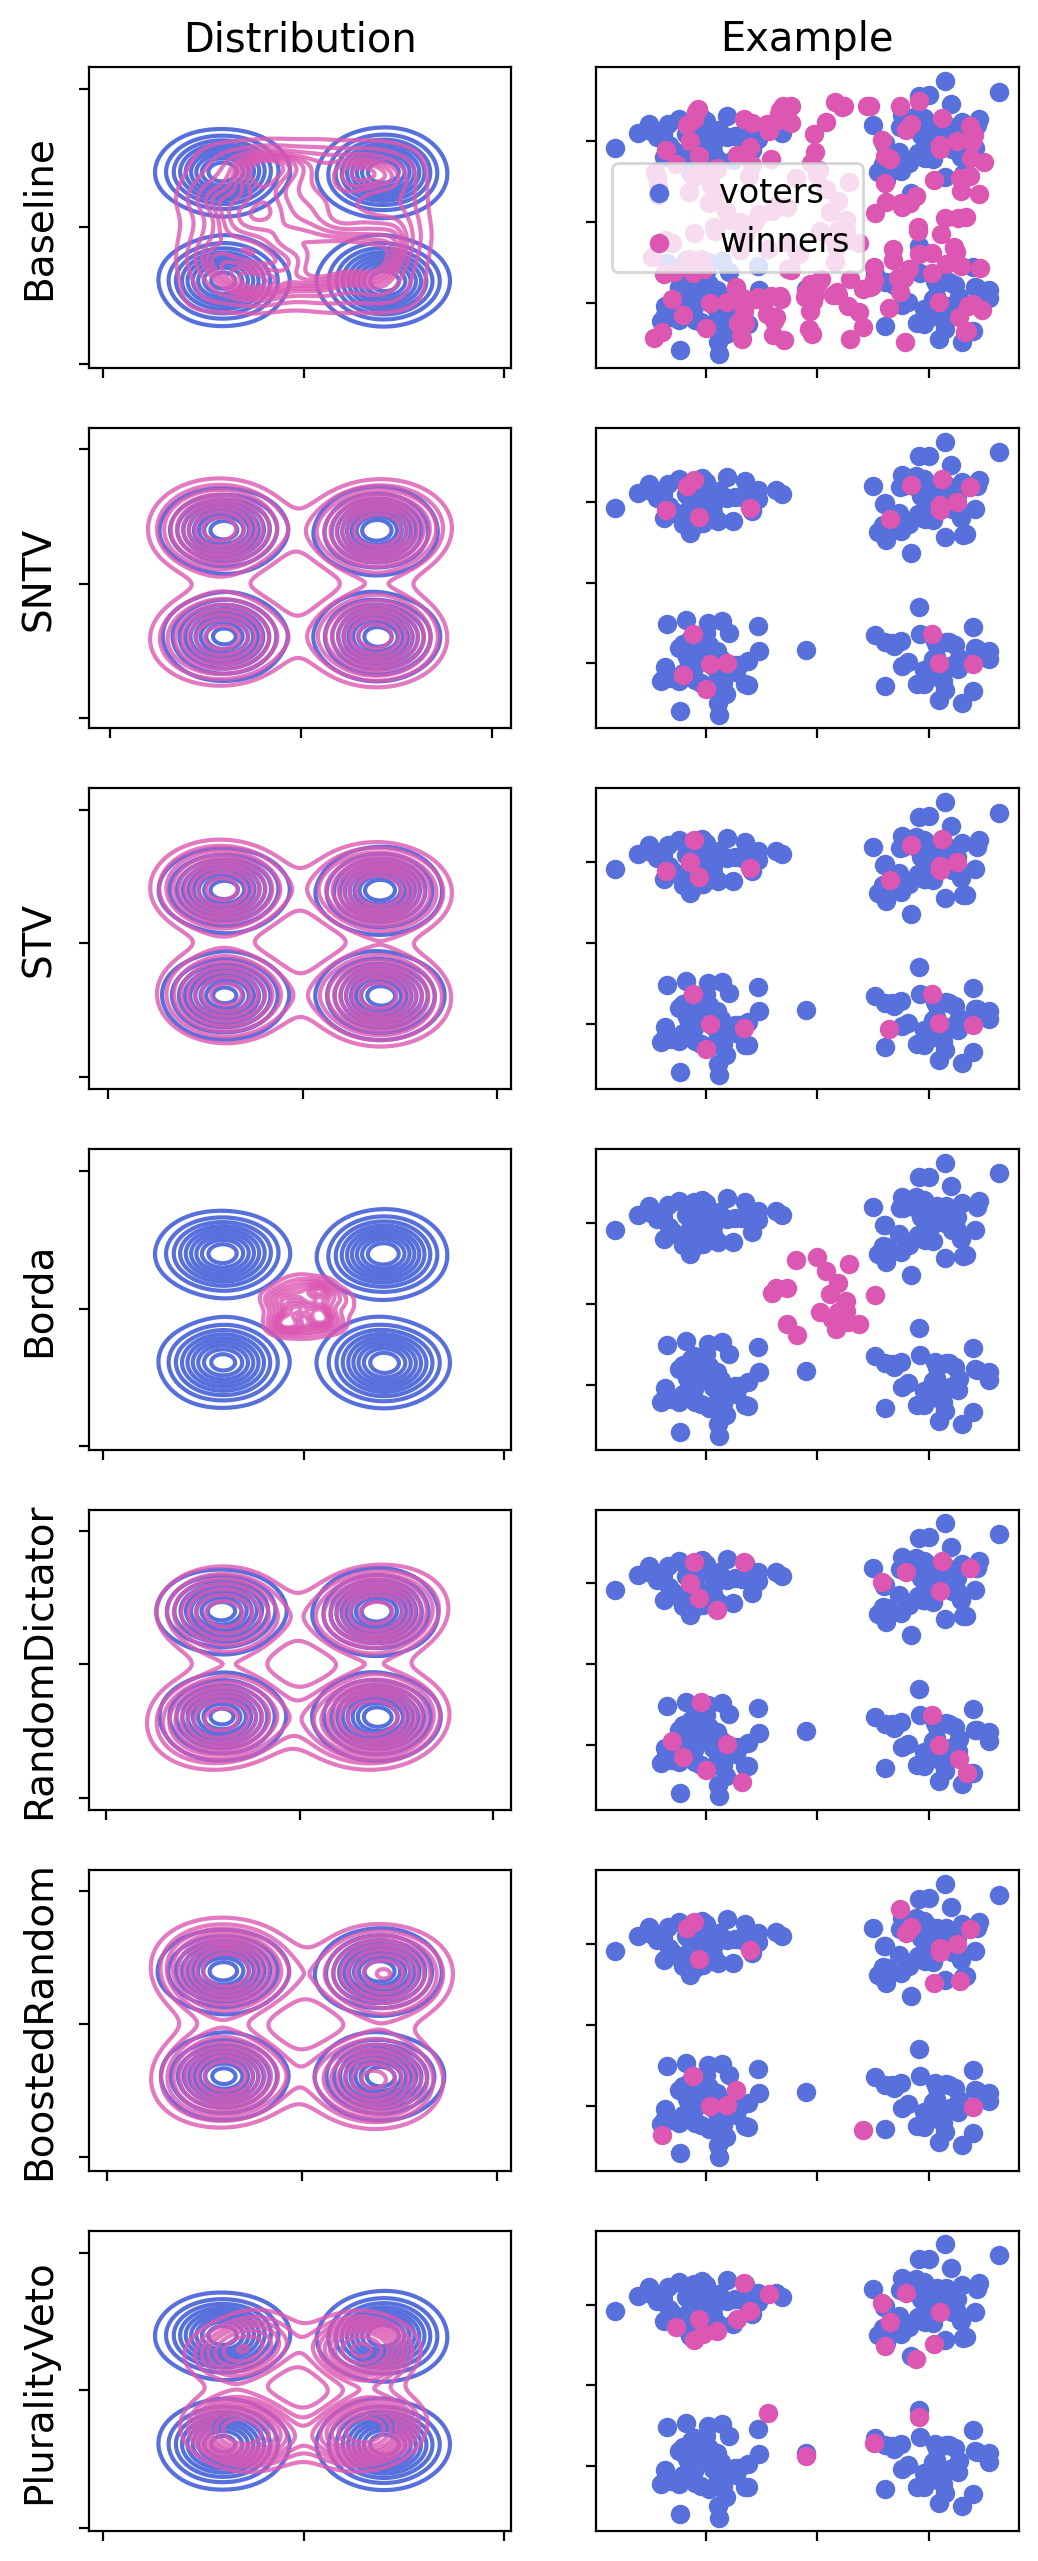

In [166]:
fig, axes = plt.subplots(7, 2, figsize=(6, 16), dpi = 200)
plt.rcParams.update({'font.size': 12})

for i, ax in enumerate(axes.flat):
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

vc = pal[5]
cc = pal[7]

# Baseline
sns.kdeplot(data=voter_samples, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, ax = axes[0][0])
sns.kdeplot(data=candidate_samples, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, ax = axes[0][0])
axes[0][0].set_title('Distribution')
axes[0][0].set_ylabel('Baseline')
axes[0][0].set_xlabel('')

axes[0][1].scatter(sampled_voter_positions[0][:,0], sampled_voter_positions[0][:,1], label = 'voters', color = vc)
axes[0][1].scatter(sampled_candidate_positions[0][:,0], sampled_candidate_positions[0][:,1], label = 'winners', color = cc)
axes[0][1].set_title('Example')
axes[0][1].legend()


# SNTV
sns.kdeplot(data=voter_samples, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, label = 'voters', ax = axes[1][0])
sns.kdeplot(data=sntv_samples, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, label = 'winners', ax = axes[1][0])
axes[1][0].set_ylabel('SNTV')
axes[1][0].set_xlabel('')

axes[1][1].scatter(sampled_voter_positions[0][:,0], sampled_voter_positions[0][:,1], label = 'voters', color = vc)
axes[1][1].scatter(sampled_sntv_winners[0][:,0], sampled_sntv_winners[0][:,1], label = 'winners', color = cc)

# STV
sns.kdeplot(data=voter_samples, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, label = 'voters', ax = axes[2][0])
sns.kdeplot(data=stv_samples, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, label = 'winners', ax = axes[2][0])
axes[2][0].set_ylabel('STV')
axes[2][0].set_xlabel('')

axes[2][1].scatter(sampled_voter_positions[0][:,0], sampled_voter_positions[0][:,1], label = 'voters', color = vc)
axes[2][1].scatter(sampled_stv_winners[0][:,0], sampled_stv_winners[0][:,1], label = 'winners', color = cc)

# Borda
sns.kdeplot(data=voter_samples, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, label = 'voters', ax = axes[3][0])
sns.kdeplot(data=borda_samples, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, label = 'winners', ax = axes[3][0])
axes[3][0].set_ylabel('Borda')
axes[3][0].set_xlabel('')

axes[3][1].scatter(sampled_voter_positions[0][:,0], sampled_voter_positions[0][:,1], label = 'voters', color = vc)
axes[3][1].scatter(sampled_borda_winners[0][:,0], sampled_borda_winners[0][:,1], label = 'winners', color = cc)


# Random Dictator
sns.kdeplot(data=voter_samples, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, label = 'voters', ax = axes[4][0])
sns.kdeplot(data=random_samples, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, label = 'winners', ax = axes[4][0])
axes[4][0].set_ylabel('RandomDictator')
axes[4][0].set_xlabel('')

axes[4][1].scatter(sampled_voter_positions[0][:,0], sampled_voter_positions[0][:,1], label = 'voters', color = vc)
axes[4][1].scatter(sampled_random_winners[0][:,0], sampled_random_winners[0][:,1], label = 'winners', color = cc)


# Boosted Random
sns.kdeplot(data=voter_samples, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, label = 'voters', ax = axes[5][0])
sns.kdeplot(data=boosted_random_samples, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, label = 'winners', ax = axes[5][0])
axes[5][0].set_ylabel('BoostedRandom')
axes[5][0].set_xlabel('')

axes[5][1].scatter(sampled_voter_positions[0][:,0], sampled_voter_positions[0][:,1], label = 'voters', color = vc)
axes[5][1].scatter(sampled_boosted_random_winners[0][:,0], sampled_boosted_random_winners[0][:,1], label = 'winners', color = cc)


# Plurality Veto
sns.kdeplot(data=voter_samples, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, label = 'voters', ax = axes[6][0])
sns.kdeplot(data=plurality_veto_samples, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, label = 'winners', ax = axes[6][0])
axes[6][0].set_ylabel('PluralityVeto')
axes[6][0].set_xlabel('')

axes[6][1].scatter(sampled_voter_positions[0][:,0], sampled_voter_positions[0][:,1], label = 'voters', color = vc)
axes[6][1].scatter(sampled_plurality_veto_winners[0][:,0], sampled_plurality_veto_winners[0][:,1], label = 'winners', color = cc)
plt.savefig('figures/4gaussian.png', bbox_inches='tight')

### Representativeness

In [128]:
def cost(voter_positions, candidate_positions):
    cost_sum = 0
    for v in voter_positions:
        for c in candidate_positions:
            cost_sum += distance(v,c)
    return cost_sum

In [122]:
def best_group_cost(voter_positions, candidate_positions, size):
    individual_candidate_costs = []

    for c in candidate_positions:
        cand_cost = cost(voter_positions, [c])
        individual_candidate_costs.append(cand_cost)

    top_cands = np.argsort(individual_candidate_costs)[:size]
    return cost(voter_positions, candidate_positions[top_cands,:])

In [130]:
def representativeness(voter_positions, candidate_positions, groups, winners):
    n_voters = len(voter_positions)
    max_epsilon = 0

    for g in groups:
        G = voter_positions[g,:]
        cost1 = best_group_cost(G, winners, int(len(g)/n_voters * k))
        cost2 = best_group_cost(G, candidate_positions, int(len(g)/n_voters * k))
        eps = np.abs(cost1 - cost2)

        if eps > max_epsilon:
            max_epsilon = eps

    return max_epsilon

In [162]:
sntv_represent = np.zeros(samples)
stv_represent = np.zeros(samples)
borda_represent = np.zeros(samples)
random_represent = np.zeros(samples)
boosted_random_represent = np.zeros(samples)
plurality_veto_represent = np.zeros(samples)

for s in range(samples):
    voter_positions = sampled_voter_positions[s]
    candidate_positions = sampled_candidate_positions[s]

    # partition to groups
    kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(voter_positions)
    groups = [[j for j in range(len(kmeans.labels_)) if kmeans.labels_[j] == i] for i in range(4)]
    
    sntv_represent[s] = representativeness(voter_positions, candidate_positions, groups, sampled_sntv_winners[s])
    stv_represent[s] = representativeness(voter_positions, candidate_positions, groups, sampled_stv_winners[s])
    borda_represent[s] = representativeness(voter_positions, candidate_positions, groups, sampled_borda_winners[s])
    random_represent[s] = representativeness(voter_positions, candidate_positions, groups, sampled_random_winners[s])
    boosted_random_represent[s] = representativeness(voter_positions, candidate_positions, groups, sampled_boosted_random_winners[s])
    plurality_veto_represent[s] = representativeness(voter_positions, candidate_positions, groups, sampled_plurality_veto_winners[s])

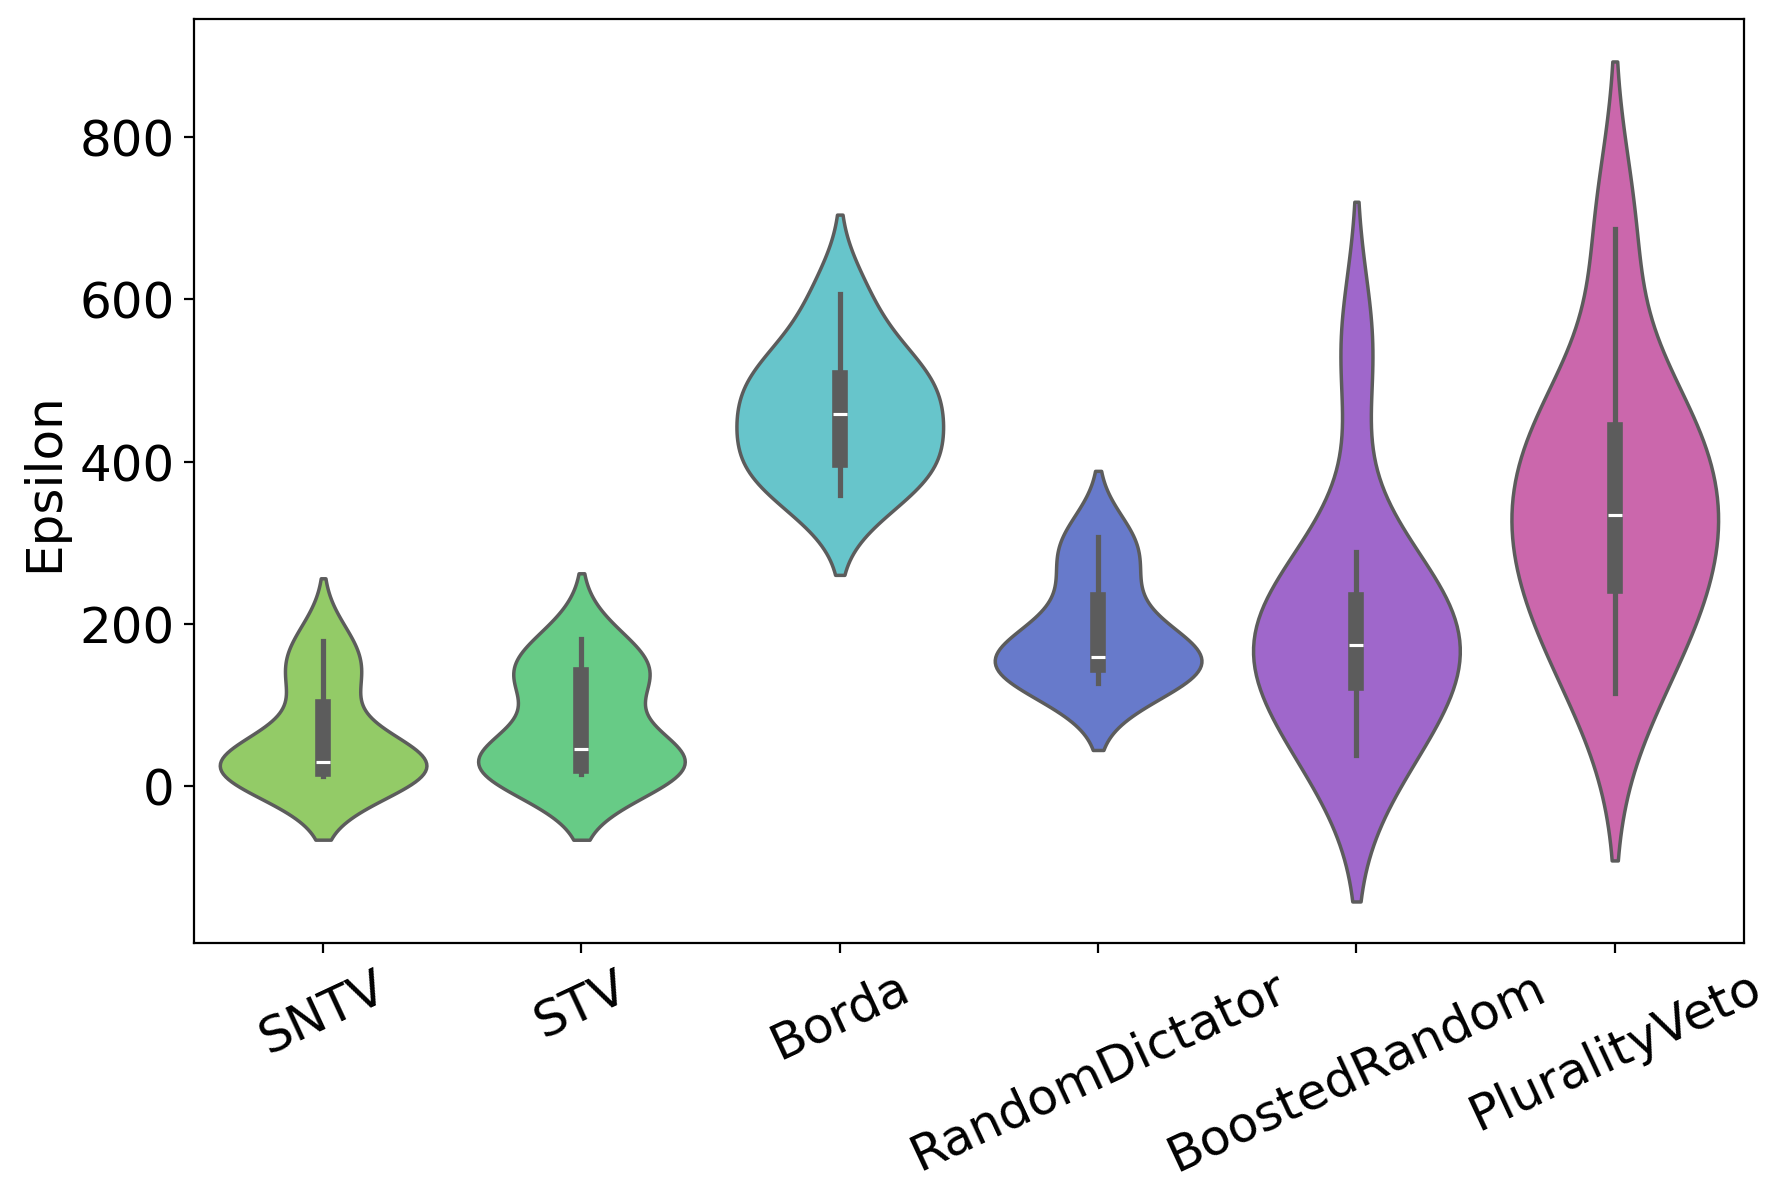

In [163]:
# Combine the arrays into a list
represent_data = [sntv_represent,stv_represent,borda_represent,random_represent,boosted_random_represent,plurality_veto_represent]

plt.rcParams.update({'font.size': 18})
# Create a violin plot
plt.figure(figsize=(10, 6), dpi = 200)
ax = sns.violinplot(data=represent_data, palette = pal[2:], alpha = 1)
for violin in ax.collections:
    violin.set_alpha(1)
plt.xticks(ticks=np.arange(6), labels=['SNTV', 'STV', 'Borda', 'RandomDictator', 'BoostedRandom', 'PluralityVeto'], rotation=25)
plt.ylabel('Epsilon')
plt.savefig('figures/4gaussian_representation_clustered.png', bbox_inches='tight')
plt.show()